In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import arch
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import quantstats as qs

from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))

In [2]:
universe = {"VNQ": 'Vanguard Real Estate Index Fund',
"XLK": 'Technology Select Sector SPDR Fund',
"XLE": 'Energy Select Sector SPDR Fund',
"XLV": 'Health Care Select Sector SPDR Fund',
"XLF": 'Financial Select Sector SPDR Fund',
"XLI": 'Industrials Select Sector SPDR Fund',
"XLB": 'Materials Select Sector SPDR Fund',
"XLY": 'Consumer Discretionary Select Sector SPDR Fund',
"XLP": 'Consumer Staples Select Sector SPDR Fund',
"XLU": 'Utilities Select Sector SPDR Fund',
           }


symbols = universe.keys()
tickers = [yf.Ticker(symbol) for symbol in symbols]

In [3]:
special_exchanges = {}

In [4]:
exchanges = {}
for symbol in symbols:
    exchanges[symbol] = 'SMART' if not symbol in special_exchanges else special_exchanges[symbol]

In [5]:
def get_data(ticker):
    data = ticker.history(period='max')
    return data['Close'].rename(ticker.ticker)

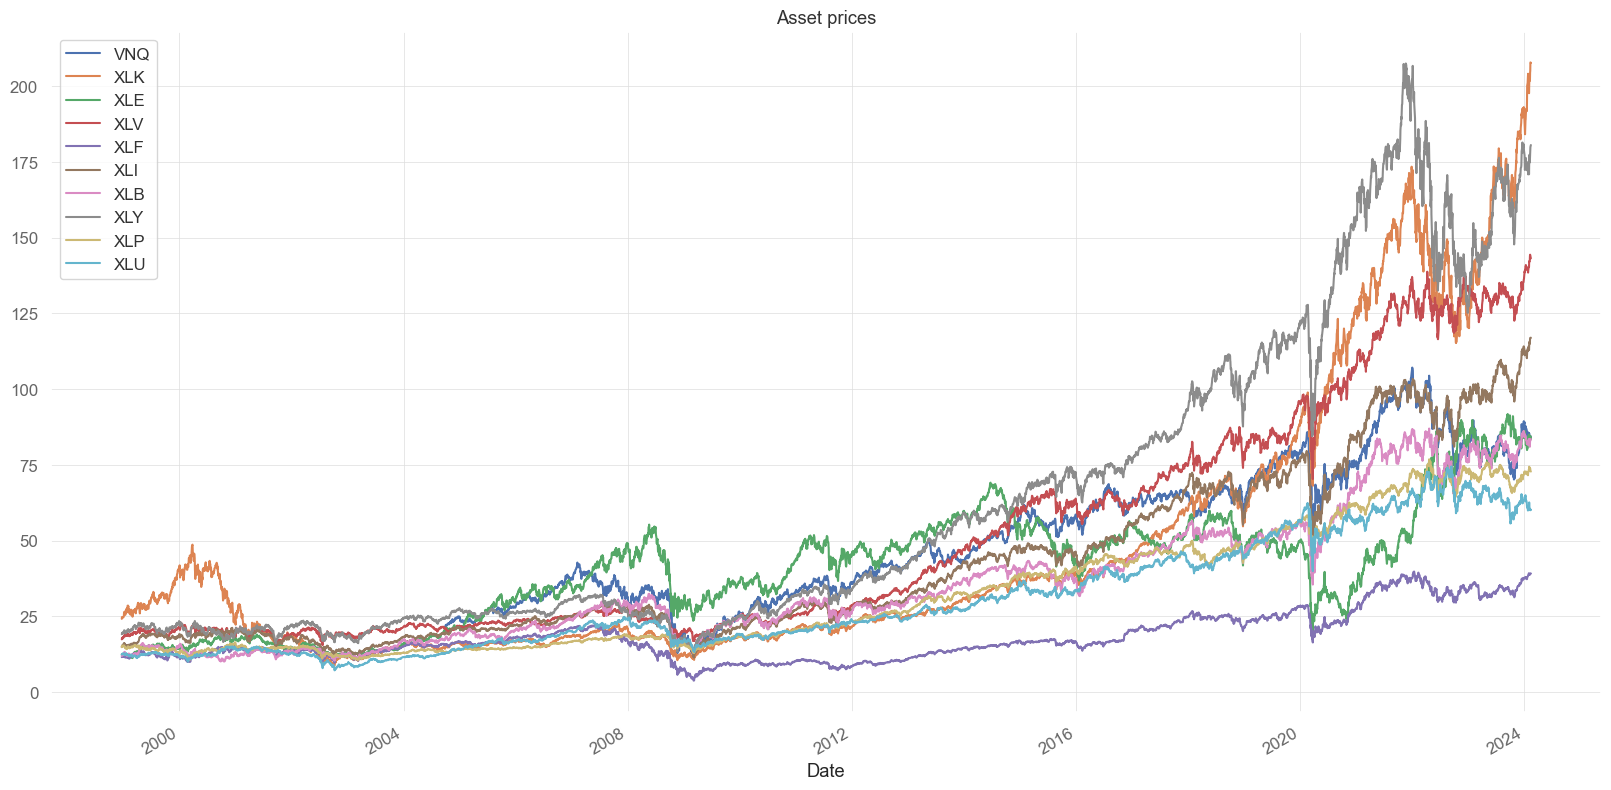

In [6]:
full_df = pd.DataFrame({symbol.ticker: get_data(symbol) for symbol in tickers})
full_df.plot(figsize=(20,10), grid=True, title='Asset prices');
full_df.index = full_df.index.tz_localize(None)

In [7]:
[print(col, full_df[col].first_valid_index()) for col in full_df.columns]

VNQ 2004-09-29 00:00:00
XLK 1998-12-22 00:00:00
XLE 1998-12-22 00:00:00
XLV 1998-12-22 00:00:00
XLF 1998-12-22 00:00:00
XLI 1998-12-22 00:00:00
XLB 1998-12-22 00:00:00
XLY 1998-12-22 00:00:00
XLP 1998-12-22 00:00:00
XLU 1998-12-22 00:00:00


[None, None, None, None, None, None, None, None, None, None]

<Axes: >

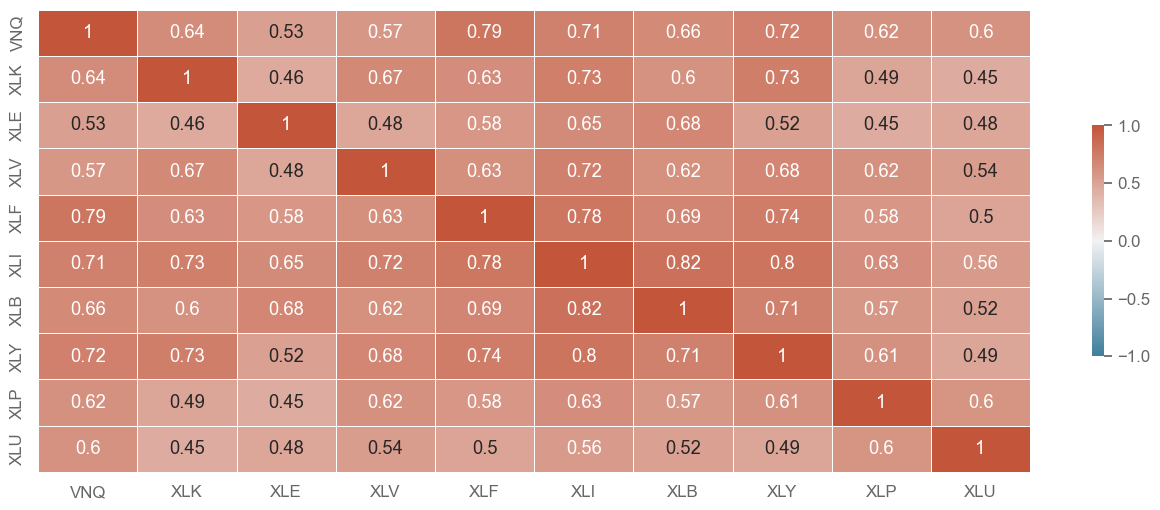

In [8]:
import seaborn as sns
corr = full_df.pct_change().corr()
f, ax = plt.subplots(figsize=(16, 6))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, cmap=cmap, vmax=1,vmin=-1, center=0,
            linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

In [9]:
def ewmac_forecast_scalar(Lfast, Lslow):
    fsdict=dict(l2_8=10.6, l4_16=7.5, l8_32=5.3, l16_64=3.75, l32_128=2.65, l64_256=1.87)
    
    lkey="l%d_%d" % (Lfast, Lslow)
    
    if lkey in fsdict:
        return fsdict[lkey]
    else:
        print ("Warning: No scalar defined for Lfast=%d, Lslow=%d, using default of 1.0" % (Lfast, Lslow))
        return 1.0
   
def ewmac(price, Lfast=16):
    vol_lookback = 25
    
    Lslow=4*Lfast
    
    fast_ewma=price.ewm(span=Lfast).mean()
    slow_ewma=price.ewm(span=Lslow).mean()
    raw_ewmac=fast_ewma - slow_ewma
    
    stdev_returns=price.diff().ewm(span=vol_lookback).std()
    vol_adj_ewmac=raw_ewmac/stdev_returns
    
    f_scalar=ewmac_forecast_scalar(Lfast, Lslow)

    forecast=vol_adj_ewmac*f_scalar
    
    return (np.maximum(np.minimum(forecast, 20), -20))/20

In [10]:
ewmacs = pd.DataFrame(index = full_df.index)
avg_ewmacs = pd.DataFrame(index = full_df.index)
lengths = [16, 32, 64]
for symbol in symbols:
    for Lfast in lengths:
        ewmacs[f'{symbol}_{Lfast}'] = ewmac(full_df[symbol], Lfast)
        if not symbol in avg_ewmacs.columns:
            avg_ewmacs[symbol] = ewmac(full_df[symbol], Lfast)
        else:
            avg_ewmacs[symbol] += ewmac(full_df[symbol], Lfast)
    avg_ewmacs[symbol] /= len(lengths)
avg_ewmacs = avg_ewmacs.shift()

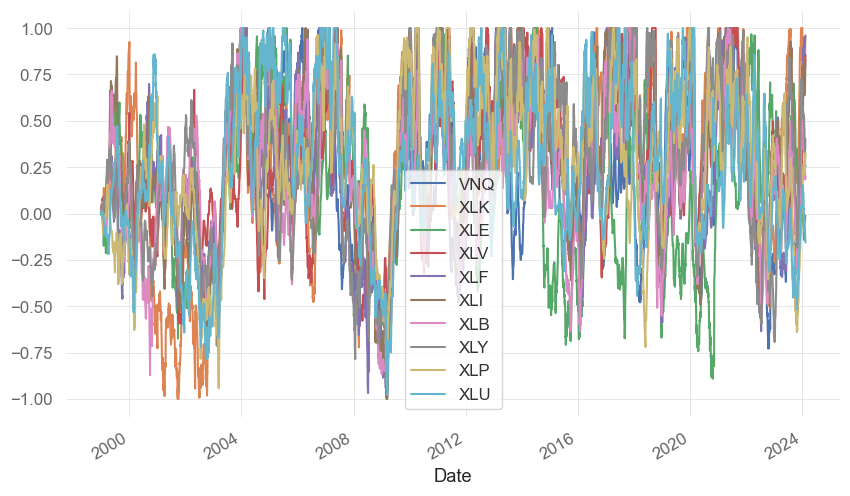

In [11]:
avg_ewmacs.plot();

In [12]:
#https://engineeredportfolio.com/2018/05/02/accelerating-dual-momentum-investing/
def dual_momentum(price, lengths=[22, 22*3, 22*6]):
    vol_lookback = 25
    stdev_returns=price.diff().ewm(span=vol_lookback).std()
    returns = pd.DataFrame()
    for l in lengths:
        returns[l] = price.pct_change(l)/stdev_returns 
    returns = returns.sum(axis=1)/len(lengths)
    return returns

In [13]:
avg_mom = pd.DataFrame(index = full_df.index)
avg_mom = pd.DataFrame([dual_momentum(full_df[symbol]) for symbol in symbols], index=symbols).T
avg_mom = avg_mom.resample('D').last().ffill().fillna(method='ffill')
avg_mom = avg_mom.shift(1)
avg_mom_full = avg_mom.copy()

In [14]:
avg_mom_full

,VNQ,XLK,XLE,XLV,XLF,XLI,XLB,XLY,XLP,XLU
Date,,,,,,,,,,
1998-12-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1998-12-23,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1998-12-24,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1998-12-25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1998-12-26,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
2024-02-08,0.038756,0.075854,-0.016637,0.118138,0.483028,0.113721,0.022810,0.035780,0.065616,-0.062291
2024-02-09,0.031647,0.072666,-0.009942,0.108748,0.423475,0.105033,0.014676,0.033520,0.057698,-0.080705
2024-02-10,0.029768,0.082338,-0.011891,0.108125,0.454146,0.113056,0.020456,0.039885,0.034370,-0.076861


In [15]:
#rebalancing_dates = pd.date_range(start=datetime.date(2005,1,1), end = datetime.datetime.today(), freq='M')
#rebalancing_dates

In [16]:
dates_df = pd.DataFrame(index = full_df.index)
dates_df['Date'] = dates_df.index
reb_dates = list(dates_df.groupby([dates_df['Date'].dt.year, dates_df['Date'].dt.month], as_index=False).last()['Date'].values)
rebalancing_dates = [pd.to_datetime(dt).date() for dt in reb_dates if dt >= pd.to_datetime('2005-01-01')]

In [17]:
def return_weights(input_dfs, min_val=0, num_assets=5):
    
    weights = pd.DataFrame()
    for i, date in enumerate(rebalancing_dates):
        
        date_weights = {}
        date_weights['Date'] = date
        long = []
        
        for input_df in input_dfs:
            sorted_values = input_df[:date].iloc[-1].sort_values(ascending=False)
            
            if not len(sorted_values[sorted_values > min_val]):
                print(f'{date}: No positive: all in cash')
            else:
                long.extend(list(sorted_values[sorted_values > min_val].index[:num_assets]))
                print(print(f'{date}: {len(long)}'))
                
                """
                tt = sorted_values[sorted_values > min_val][:num_assets]
                tt/=tt.sum()
                date_weights.update(tt.to_dict())
                """
                
        long = list(set(long))
    
        for ticker in long:
            date_weights[ticker] = 1/len(long)
            
        for ticker in input_df.columns:
            if ticker not in long:
                date_weights[ticker] = 0
                
        weights = pd.concat([weights, pd.DataFrame.from_dict(date_weights, orient='index').T], axis=0)
        
    weights.set_index('Date', inplace=True)
    weights = weights[full_df.columns]
    weights.index = pd.to_datetime(weights.index)
    
    return weights

In [18]:
avg_mom[:rebalancing_dates[-1]].iloc[-1].sort_values(ascending=False)

XLF    0.454146
XLI    0.113056
XLV    0.108125
XLK    0.082338
XLY    0.039885
XLP    0.034370
VNQ    0.029768
XLB    0.020456
XLE   -0.011891
XLU   -0.076861
Name: 2024-02-12 00:00:00, dtype: float64

In [19]:
num_assets=5
dfw_ewmac = return_weights([avg_ewmacs], min_val=0., num_assets=num_assets)
dfw_mom = return_weights([avg_mom], min_val=0., num_assets=num_assets)
#dfw_comb = return_weights([avg_ewmacs, avg_mom])

2005-01-31: 5
None
2005-02-28: 5
None
2005-03-31: 5
None
2005-04-29: 5
None
2005-05-31: 5
None
2005-06-30: 5
None
2005-07-29: 5
None
2005-08-31: 5
None
2005-09-30: 5
None
2005-10-31: 5
None
2005-11-30: 5
None
2005-12-30: 5
None
2006-01-31: 5
None
2006-02-28: 5
None
2006-03-31: 5
None
2006-04-28: 5
None
2006-05-31: 5
None
2006-06-30: 5
None
2006-07-31: 5
None
2006-08-31: 5
None
2006-09-29: 5
None
2006-10-31: 5
None
2006-11-30: 5
None
2006-12-29: 5
None
2007-01-31: 5
None
2007-02-28: 5
None
2007-03-30: 5
None
2007-04-30: 5
None
2007-05-31: 5
None
2007-06-29: 5
None
2007-07-31: 5
None
2007-08-31: 5
None
2007-09-28: 5
None
2007-10-31: 5
None
2007-11-30: 5
None
2007-12-31: 5
None
2008-01-31: 2
None
2008-02-29: 2
None
2008-03-31: 3
None
2008-04-30: 5
None
2008-05-30: 5
None
2008-06-30: 3
None
2008-07-31: No positive: all in cash
2008-08-29: 2
None
2008-09-30: 1
None
2008-10-31: No positive: all in cash
2008-11-28: No positive: all in cash
2008-12-31: No positive: all in cash
2009-01-30: No p

In [20]:
def run_backtest(weights, aum):
    """
    
    """
    # Create a rebalancing schedule (monthly)
    rebalancing_dates = weights.index

    # Initialize portfolio value and track performance
    portfolio_value = [aum]  # Start with an initial investment equal to aum
    portfolio_weights = []
    dates = []
    reb_dates = []

    for i in range(1, len(full_df)):
        
        date = full_df.index[i]
        
        if date < rebalancing_dates[0]:
            continue
        
        if date == full_df.last_valid_index():    
            continue
        
        current_prices = full_df.loc[date:].iloc[0]  #double check, we shifted the momentum signal (and so the weights) so we should be able to trade on this close
        # Check if it's the end of the month (rebalancing date)
        if date in rebalancing_dates:
            reb_dates.append(date)
            # Get the current weights and prices at the rebalancing date
            current_weights = weights.loc[date].to_dict()
            total_investment = portfolio_value[-1]
            
            total_investment = total_investment - (len(weights.columns)/2) # 1$ transaction cost

            # Calculate the number of shares to hold for each asset based on target weights
            shares_to_hold = {asset: total_investment * weight / price
                              for asset, weight, price in zip(current_weights.keys(),
                                                              current_weights.values(),
                                                              current_prices.values)
                            }
            #print(shares_to_hold, current_prices)
            # Update the portfolio value with the total investment after rebalancing
            total_investment = sum(shares_to_hold[asset] * price
                                   for asset, price 
                                   in zip(current_prices.index, current_prices.values))
        
            portfolio_value.append(total_investment)
            portfolio_weights.append(current_weights)
            
        else:
            # Interpolate the portfolio value for the days between rebalancing dates            
            total_investment = sum(shares_to_hold[asset] * price
                                   for asset, price 
                                   in zip(current_prices.index, current_prices.values))
            
            portfolio_value.append(total_investment)
        #print(date, total_investment)
        dates.append(date)

    # Convert the results to a DataFrame
    results_df = pd.DataFrame({'Cumulative': portfolio_value[1:]}, index=dates)
    results_df['Returns'] = results_df['Cumulative'].pct_change()
    results_df.index = pd.to_datetime(results_df.index)
    return results_df, reb_dates


In [21]:
full_df['CASH'] = 100

In [22]:
max_weight = 0.5
dfw_mom = dfw_mom.clip(0,max_weight)
dfw_ewmac = dfw_ewmac.clip(0,max_weight)

In [23]:
dfw_ewmac['CASH'] = 1 - dfw_ewmac.sum(axis=1)
dfw_mom['CASH'] = 1 - dfw_mom.sum(axis=1)
#dfw_comb['CASH'] = 1 - dfw_comb.sum(axis=1)

<Axes: xlabel='Date'>

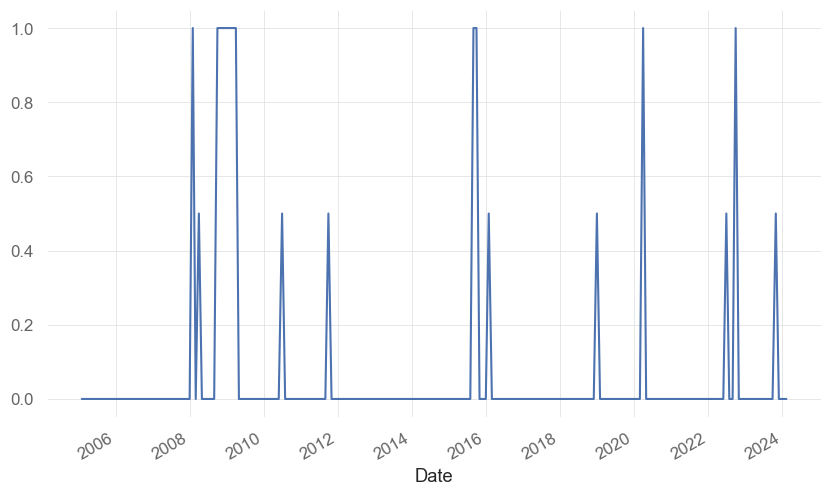

In [24]:
dfw_mom['CASH'].plot()

In [25]:
dfw_mom['2023':]

,VNQ,XLK,XLE,XLV,XLF,XLI,XLB,XLY,XLP,XLU,CASH
Date,,,,,,,,,,,
2023-01-31,0.2,0,0.2,0,0.2,0.2,0.2,0,0,0,0.0
2023-02-28,0,0,0,0,0.333333,0.333333,0.333333,0,0,0,0.0
2023-03-31,0,0.2,0.2,0,0,0.2,0.2,0,0.2,0,0.0
2023-04-28,0,0.2,0,0,0,0.2,0.2,0,0.2,0.2,0.0
2023-05-31,0,0.5,0,0,0,0,0,0.5,0,0,0.0
2023-06-30,0,0.2,0,0,0.2,0.2,0.2,0.2,0,0,0.0
2023-07-31,0,0.2,0,0,0.2,0.2,0.2,0.2,0,0,0.0
2023-08-31,0,0.2,0.2,0,0.2,0.2,0.2,0,0,0,0.0
2023-09-29,0,0.25,0.25,0,0.25,0,0,0.25,0,0,0.0


In [26]:
results_ewmac, _1 = run_backtest(dfw_ewmac, 10000)
results_mom, _2 = run_backtest(dfw_mom, 10000)
#results_comb, _3 = run_backtest(dfw_comb, 10000)

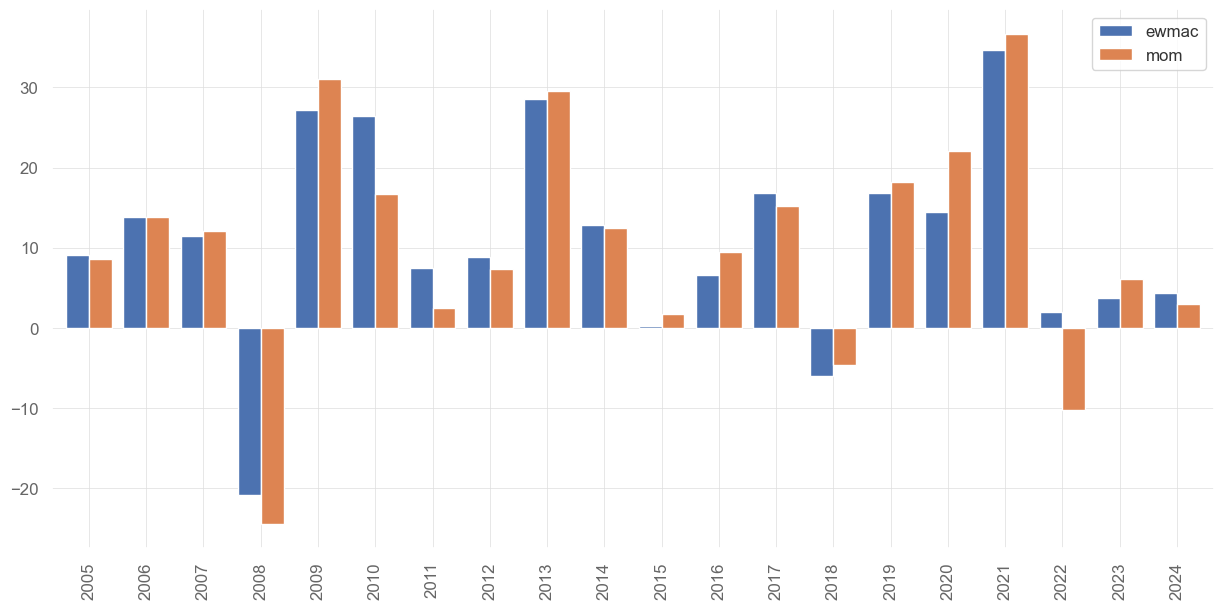

In [27]:
yearly_returns_ewmac = ((results_ewmac['Returns']).groupby([results_ewmac['Returns'].index.year]).sum()*100)
yearly_returns_mom = ((results_mom['Returns']).groupby([results_mom['Returns'].index.year]).sum()*100)
comb_returns = pd.concat([yearly_returns_ewmac, yearly_returns_mom], axis=1)
comb_returns.columns = ['ewmac', 'mom']
comb_returns.plot(kind='bar', width=0.8, figsize=(15,7));

In [28]:
import quantstats as qs

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-02-01   2005-02-01
End Period                 2024-02-09   2024-02-09
Risk-Free Rate             0.0%         0.0%
Time in Market             95.0%        96.0%

Cumulative Return          529.57%      611.53%
CAGR﹪                     6.9%         7.38%

Sharpe                     0.7          0.75
Prob. Sharpe Ratio         99.86%       99.93%
Smart Sharpe               0.63         0.68
Sortino                    0.97         1.05
Smart Sortino              0.88         0.94
Sortino/√2                 0.69         0.74
Smart Sortino/√2           0.62         0.67
Omega                      1.16         1.16

Max Drawdown               -31.68%      -31.08%
Longest DD Days            772          604
Volatility (ann.)          15.67%       15.36%
R^2                        0.86         0.86
Information Ratio          0.01         0.01
Calmar              

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2020-02-18,2020-03-23,2020-09-01,197,-31.078159,-25.246357
2,2008-05-20,2008-10-27,2009-12-28,588,-26.365062,-25.600996
3,2018-09-14,2018-12-24,2019-12-13,456,-17.590878,-15.153587
4,2015-07-21,2016-01-20,2017-02-10,571,-15.793139,-14.893037
5,2011-05-03,2011-08-08,2012-01-24,267,-15.235222,-11.630909


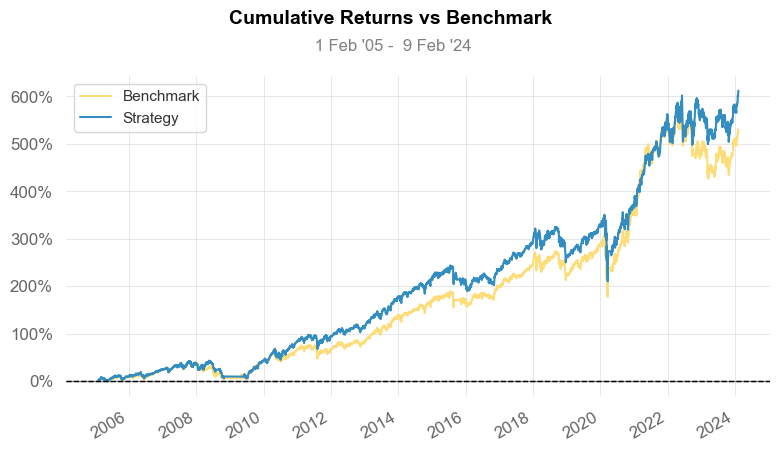

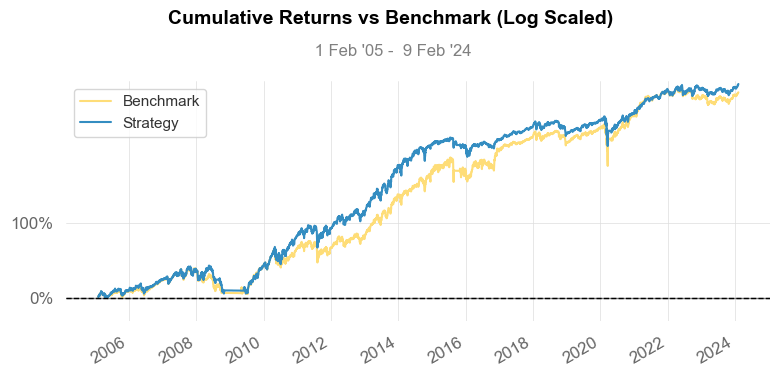

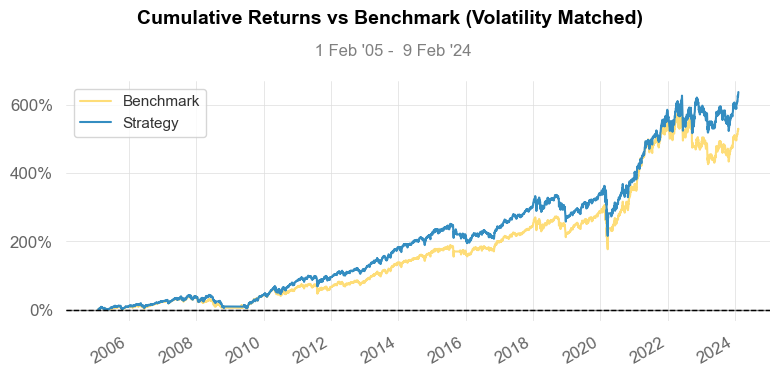

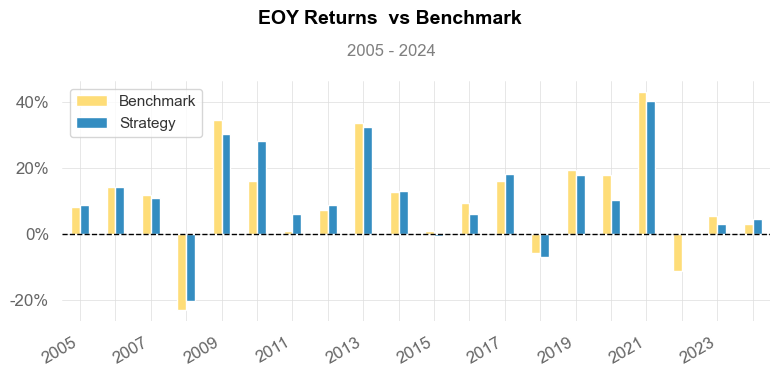

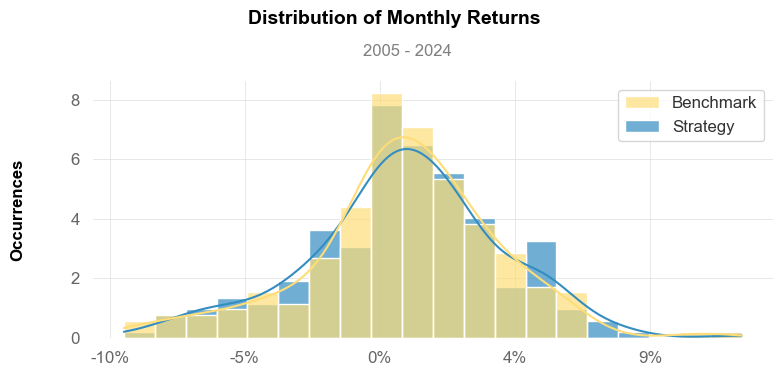

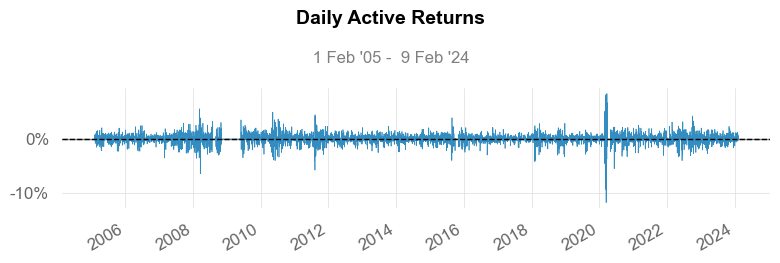

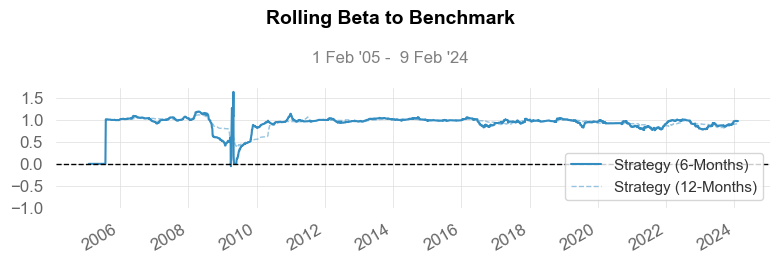

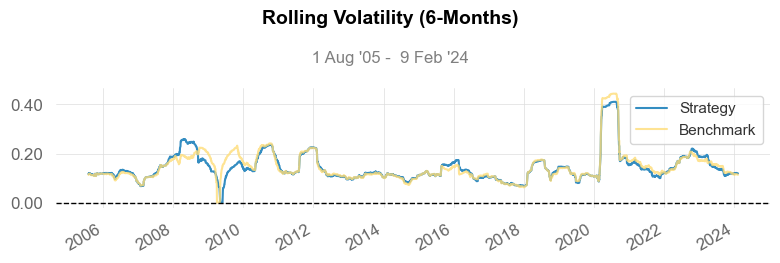

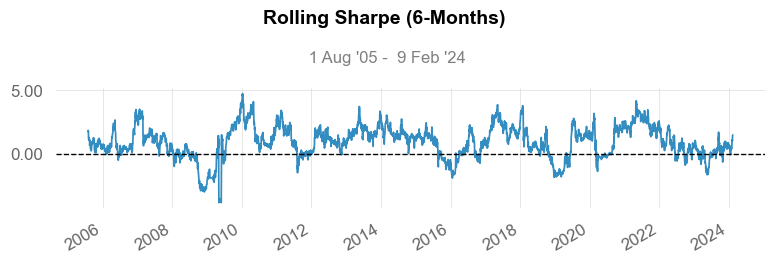

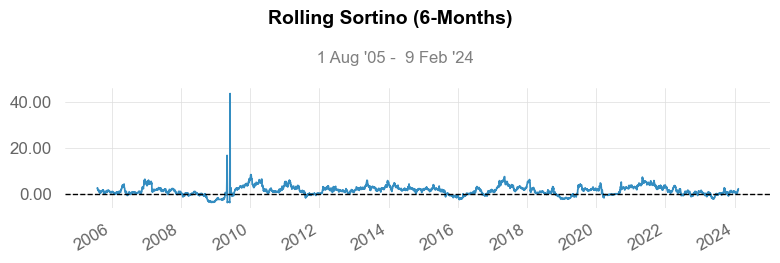

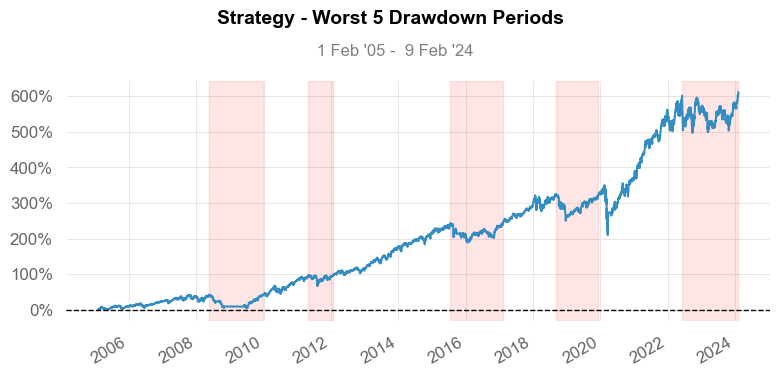

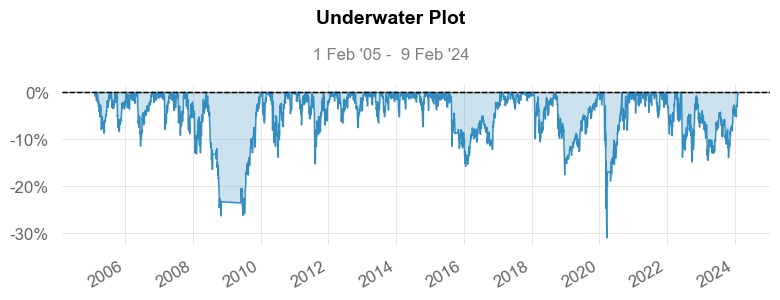

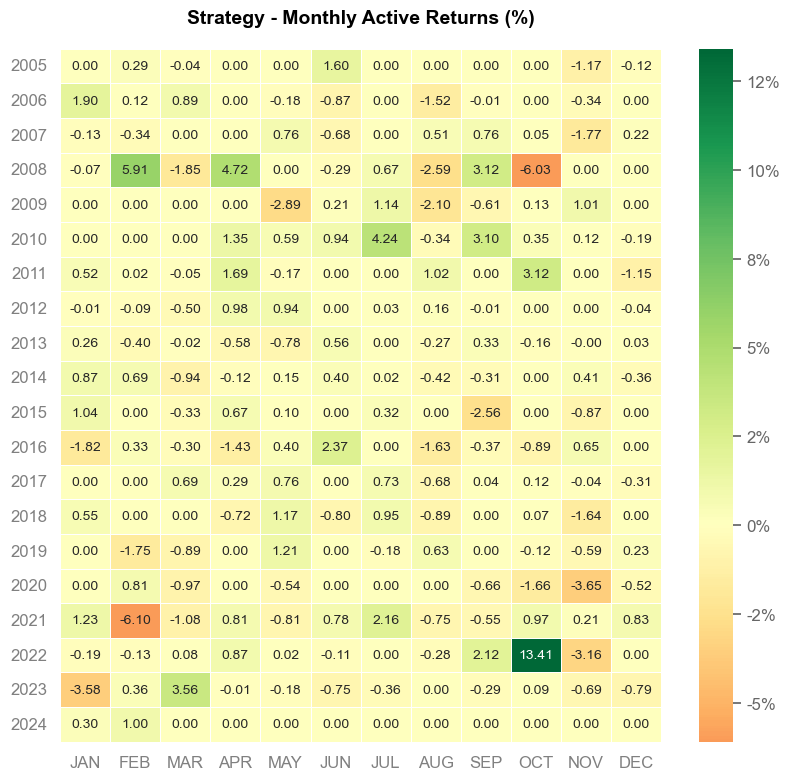

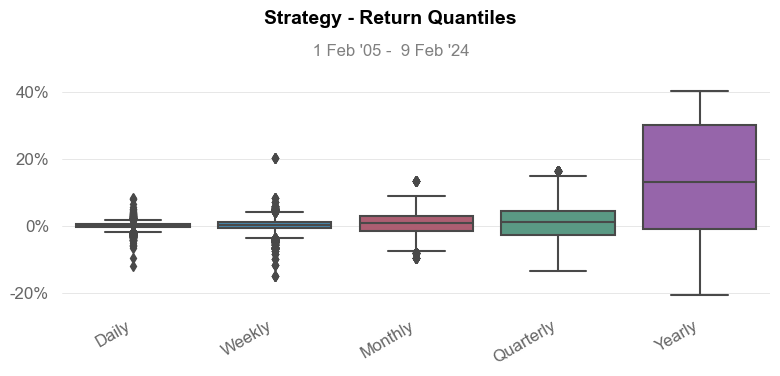

In [29]:
qs.reports.full(returns=results_ewmac['Cumulative'], 
                benchmark=results_mom['Cumulative'],
                output='report.html', 
                title='Sector Rotation Strategy')

In [30]:
dfw_ewmac['2022-09':]

,VNQ,XLK,XLE,XLV,XLF,XLI,XLB,XLY,XLP,XLU,CASH
Date,,,,,,,,,,,
2022-09-30,0,0,0.5,0,0,0,0,0,0,0.5,0.0
2022-10-31,0,0,0.5,0,0,0,0,0,0,0,0.5
2022-11-30,0,0,0.2,0.2,0.2,0.2,0,0,0.2,0,0.0
2022-12-30,0,0,0.2,0.2,0,0.2,0,0,0.2,0.2,0.0
2023-01-31,0,0,0.2,0.2,0.2,0.2,0.2,0,0,0,0.0
2023-02-28,0,0.2,0.2,0,0.2,0.2,0.2,0,0,0,0.0
2023-03-31,0,0.333333,0,0,0,0.333333,0,0,0.333333,0,0.0
2023-04-28,0,0.2,0.2,0.2,0,0.2,0,0,0.2,0,0.0
2023-05-31,0,0.25,0,0,0,0.25,0,0.25,0.25,0,0.0


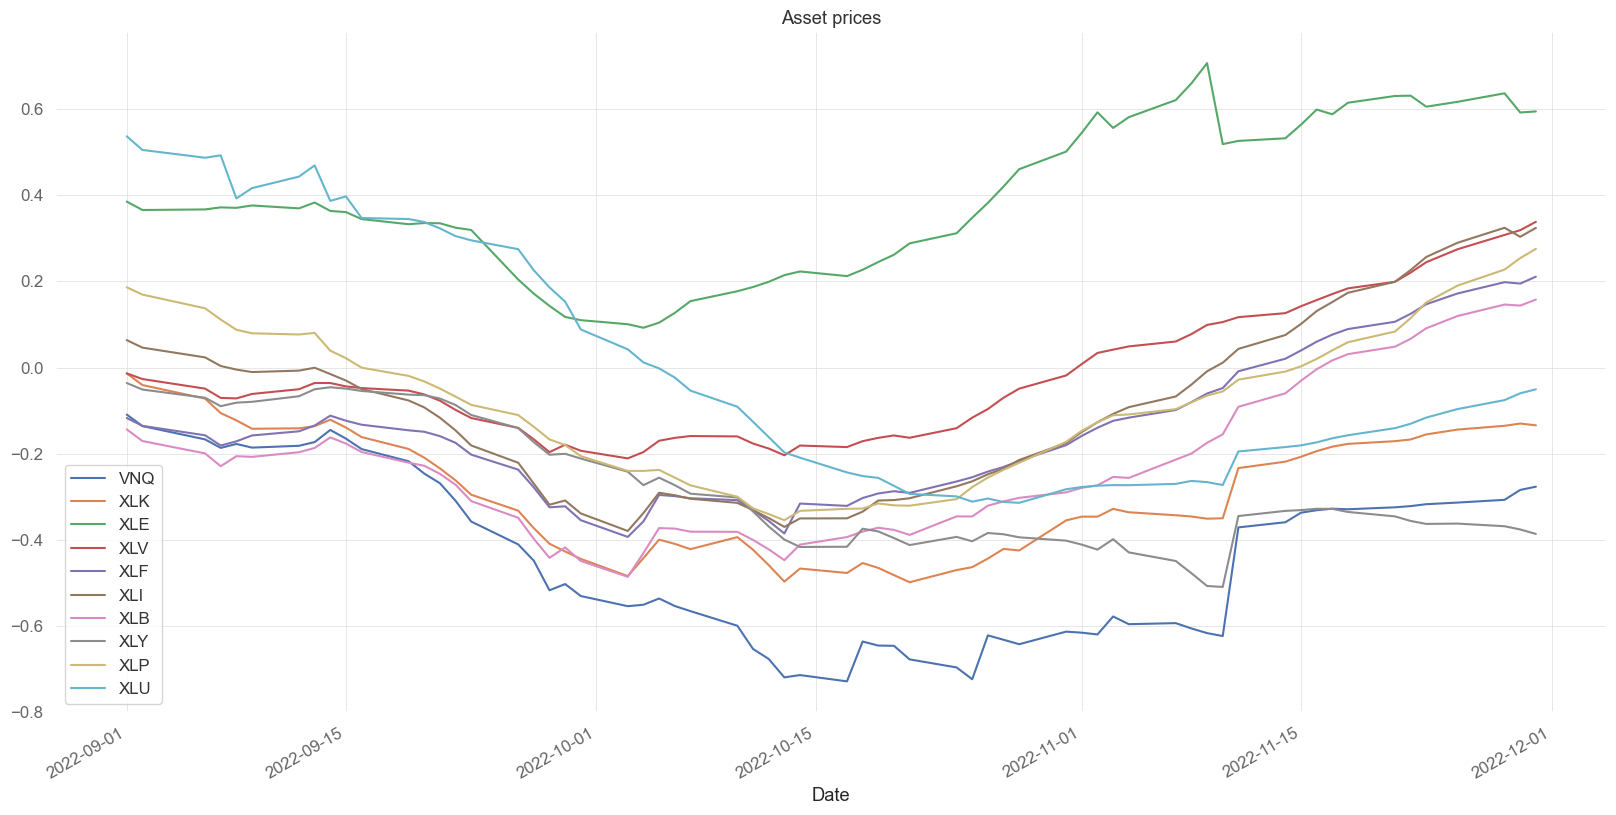

In [31]:
avg_ewmacs['2022-09':'2022-11'].plot(figsize=(20,10), grid=True, title='Asset prices');

<Axes: xlabel='Date'>

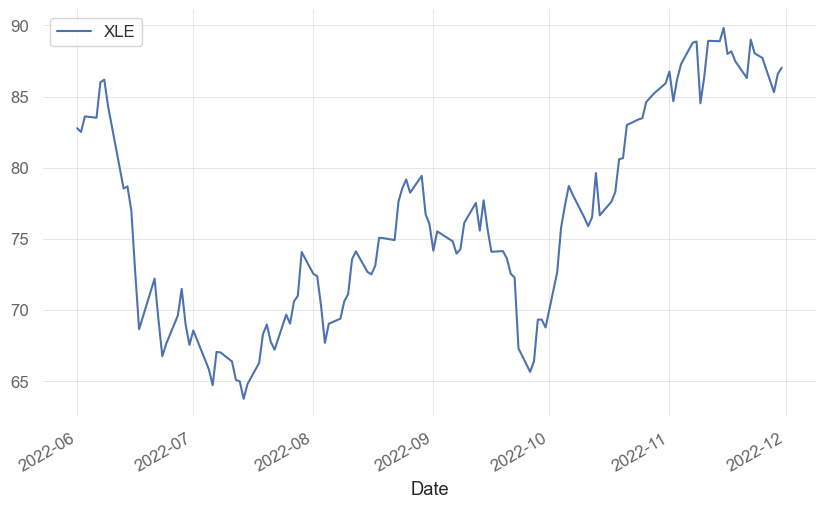

In [32]:
full_df[['XLE']]['2022-06':'2022-11'].plot()

<Axes: xlabel='Date'>

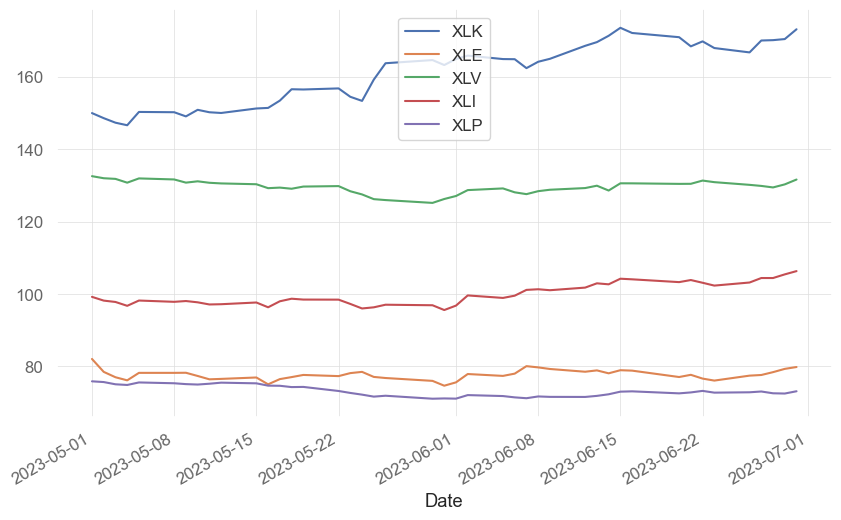

In [33]:
full_df[['XLK', 'XLE', 'XLV', 'XLI', 'XLP']]['2023-05':'2023-06'].plot()

In [34]:
results_ewmac['Returns']['2023-05']

2023-05-01    0.000132
2023-05-02   -0.013978
2023-05-03   -0.008009
2023-05-04   -0.007408
2023-05-05    0.016955
2023-05-08   -0.001878
2023-05-09   -0.003024
2023-05-10   -0.000190
2023-05-11   -0.004431
2023-05-12    0.000677
2023-05-15    0.002781
2023-05-16   -0.010547
2023-05-17    0.009953
2023-05-18    0.005643
2023-05-19    0.001929
2023-05-22   -0.003231
2023-05-23   -0.007177
2023-05-24   -0.005933
2023-05-25    0.001756
2023-05-26    0.007210
2023-05-30   -0.004474
2023-05-31   -0.000090
Name: Returns, dtype: float64

## Risk Overlay

In [35]:
from scipy.stats import t
from scipy.stats import norm
from scipy.optimize import minimize
from scipy.optimize import Bounds

class RiskMeasures:
    
    def __init__(self, confidence_level):
        self._confidence_level = confidence_level
    
    def value_at_risk(self, returns):
        return returns.quantile(self._confidence_level)

    def gaussian_var(self, returns):
        z = norm.ppf(self._confidence_level)
        s = returns.skew()
        k = returns.kurtosis()
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
        return (returns.mean() + z*returns.std(ddof=0))
        
    def expected_shortfall(self, returns):
        returns = returns[returns!=0]
        var = self.value_at_risk(returns)
        return abs(returns[returns.lt(var)].mean())

In [36]:
def fun_rolling_cvar(rets):
    rm = RiskMeasures(confidence_level=0.05)
    risk_strategy = rm.expected_shortfall(returns=rets)
    return risk_strategy

In [37]:
bm_price = get_data(yf.Ticker('IVV'))
bm_price.index = bm_price.index.tz_localize(None)

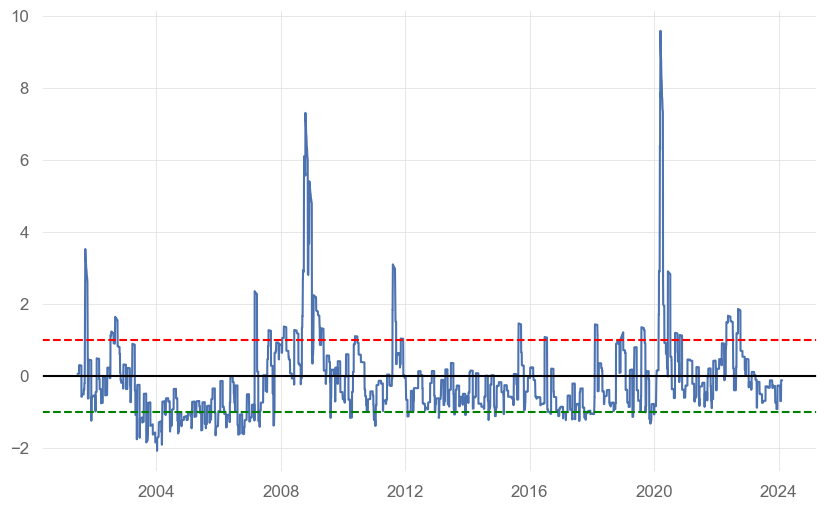

In [38]:
rolling_cvar = np.log(bm_price).diff().rolling(window=20).apply(fun_rolling_cvar)
#rolling_cvar = rolling_cvar.shift()
cvar_zscore = ((rolling_cvar - rolling_cvar.rolling(window=252*10, min_periods=252).mean())/rolling_cvar.rolling(window=252*10, min_periods=252).std())
plt.plot(cvar_zscore)
plt.axhline(0, color='black')
plt.axhline(1, color='red', linestyle='--')
plt.axhline(-1, color='green', linestyle='--')


In [39]:
risk_zscore=True

df_risk = pd.DataFrame(rolling_cvar.ewm(span=3).mean())
df_risk.columns = ['Risk']

if risk_zscore:
    df_risk['zscore'] = ((df_risk['Risk'] - df_risk['Risk'].rolling(window=252*10, min_periods=252).mean())/df_risk['Risk'].rolling(window=252*10, min_periods=252).std())
    df_risk['limit'] = 1.5
    df_risk = df_risk.shift(1)
    df_risk['breached'] = np.where(df_risk['zscore'] > df_risk['limit'], 1, 0)
else:
    df_risk['limit'] = df_risk['Risk'].rolling(window=250, min_periods=1).mean() + df_risk['Risk'].rolling(window=250, min_periods=1).std()
    df_risk = df_risk.shift(1)
    df_risk['breached'] = np.where(df_risk['Risk'] > df_risk['limit'], 1, 0)


df_risk['action'] = df_risk['breached'].diff()
df_risk = df_risk[dfw_mom.first_valid_index():] 

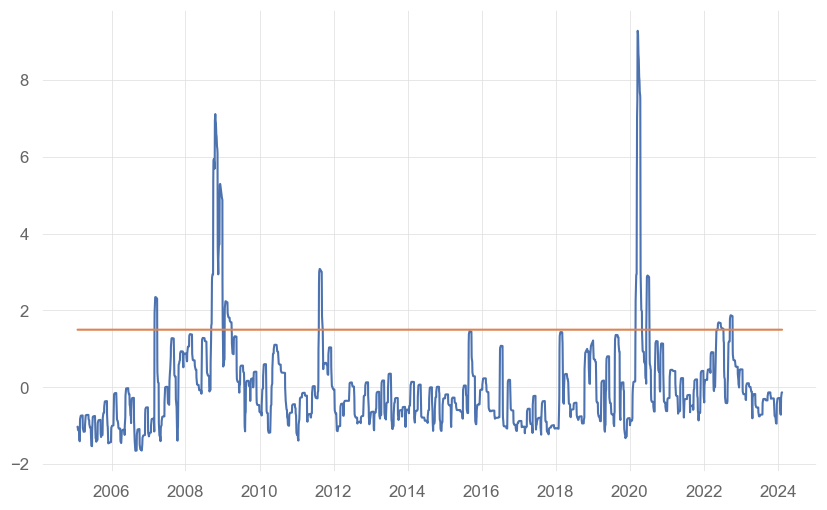

In [40]:
if risk_zscore:
    plt.plot(df_risk['zscore'])
else:
    plt.plot(df_risk['Risk'])
plt.plot(df_risk['limit'])

In [41]:
df_risk[df_risk['action'] != 0]

,Risk,zscore,limit,breached,action
Date,,,,,
2007-03-01,0.032040,1.501609,1.5,1,1.0
2007-03-28,0.029875,1.210543,1.5,0,-1.0
2008-09-11,0.033320,1.556862,1.5,1,1.0
2009-01-05,0.037780,1.137885,1.5,0,-1.0
2009-01-22,0.048550,1.878981,1.5,1,1.0
2009-04-01,0.043629,1.450056,1.5,0,-1.0
2011-08-09,0.054613,2.277229,1.5,1,1.0
2011-09-19,0.036084,0.923728,1.5,0,-1.0
2020-02-27,0.031941,1.541531,1.5,1,1.0


In [42]:
def generate_risk(input_df):
    
    dfw_risk = pd.DataFrame()
    input_df_clean = input_df.copy()
    del input_df_clean['CASH']

    for i, (index, row) in enumerate(df_risk[input_df_clean.first_valid_index():].iterrows()):
        if index > input_df_clean.index[-1]:
            continue
        else:
            given_weights = input_df_clean.loc[:index].iloc[-1]
            if index in df_risk.index:
                if (df_risk.loc[index]['breached'] == 1) and (df_risk.loc[index]['action'] == 1):
                    print('breached', index.date())
                    given_weights = pd.DataFrame(index=[index], columns = input_df_clean.columns).fillna(0).T
                    #given_weights/=2
                    dfw_risk = pd.concat([dfw_risk, pd.DataFrame(given_weights).T], axis=0)  
                elif (df_risk.loc[index]['breached'] == 0) and (df_risk.loc[index]['action'] == -1):
                    print('reinvest', index.date())
                    given_weights = pd.DataFrame(index= input_df_clean.columns, data=given_weights.values, columns = [index])
                    dfw_risk = pd.concat([dfw_risk, pd.DataFrame(given_weights).T], axis=0)  
                else:
                    if index in input_df_clean.index and (df_risk.loc[index]['breached'] == 0):
                        print('normal', index.date())
                        dfw_risk = pd.concat([dfw_risk, pd.DataFrame(given_weights).T], axis=0) 
                        
    dfw_risk.sort_index(inplace=True)
    dfw_risk= dfw_risk[~dfw_risk.index.duplicated(keep='last')]
    
    return dfw_risk
        

In [43]:
dfw_risk_mom = generate_risk(dfw_mom)
dfw_risk_ewmac = generate_risk(dfw_ewmac)

normal 2005-01-31
normal 2005-02-28
normal 2005-03-31
normal 2005-04-29
normal 2005-05-31
normal 2005-06-30
normal 2005-07-29
normal 2005-08-31
normal 2005-09-30
normal 2005-10-31
normal 2005-11-30
normal 2005-12-30
normal 2006-01-31
normal 2006-02-28
normal 2006-03-31
normal 2006-04-28
normal 2006-05-31
normal 2006-06-30
normal 2006-07-31
normal 2006-08-31
normal 2006-09-29
normal 2006-10-31
normal 2006-11-30
normal 2006-12-29
normal 2007-01-31
normal 2007-02-28
breached 2007-03-01
reinvest 2007-03-28
normal 2007-03-30
normal 2007-04-30
normal 2007-05-31
normal 2007-06-29
normal 2007-07-31
normal 2007-08-31
normal 2007-09-28
normal 2007-10-31
normal 2007-11-30
normal 2007-12-31
normal 2008-01-31
normal 2008-02-29
normal 2008-03-31
normal 2008-04-30
normal 2008-05-30
normal 2008-06-30
normal 2008-07-31
normal 2008-08-29
breached 2008-09-11
reinvest 2009-01-05
breached 2009-01-22
reinvest 2009-04-01
normal 2009-04-30
normal 2009-05-29
normal 2009-06-30
normal 2009-07-31
normal 2009-08-3

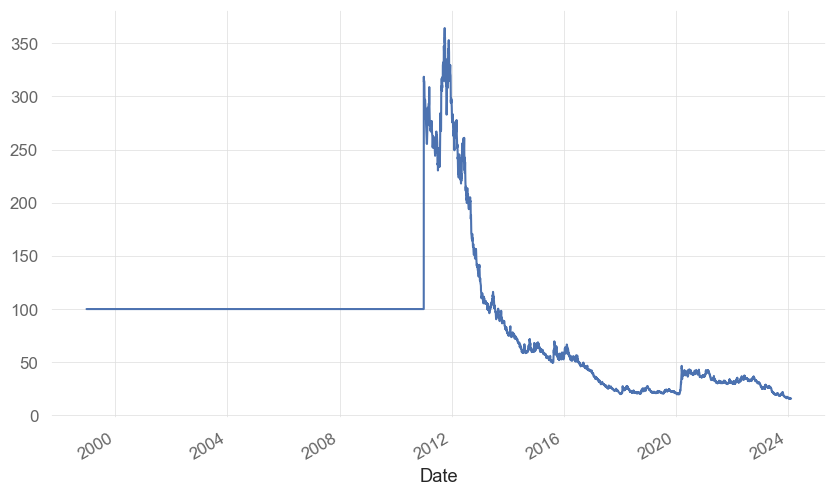

In [44]:
include_ro_etf = True
if include_ro_etf:
    del full_df['CASH']
    risk_off_etf = 'VIXM'
    long_vix = get_data(yf.Ticker(risk_off_etf)).fillna(method='ffill')
    long_vix.index = long_vix.index.tz_localize(None)
    full_df['RO'] = long_vix
    full_df['RO'] = full_df['RO'].fillna(method='ffill')
    full_df['RO'].fillna(100, inplace=True)
    full_df['CASH'] = 100
    full_df['RO'].plot()
    
    
    max_alloc_ro = 0.2
    dfw_risk_mom['RO'] = np.minimum(max_alloc_ro, 1 - dfw_risk_mom.sum(axis=1))
    dfw_risk_ewmac['RO'] = np.minimum(max_alloc_ro, 1 - dfw_risk_ewmac.sum(axis=1))
    
    dfw_risk_mom['CASH'] = 1 - dfw_risk_mom.sum(axis=1)
    dfw_risk_ewmac['CASH'] = 1 - dfw_risk_ewmac.sum(axis=1)
    
else:
    full_df['CASH'] = 100
    dfw_risk_mom['CASH'] = 1 - dfw_risk_mom.sum(axis=1)
    dfw_risk_ewmac['CASH'] = 1 - dfw_risk_ewmac.sum(axis=1)

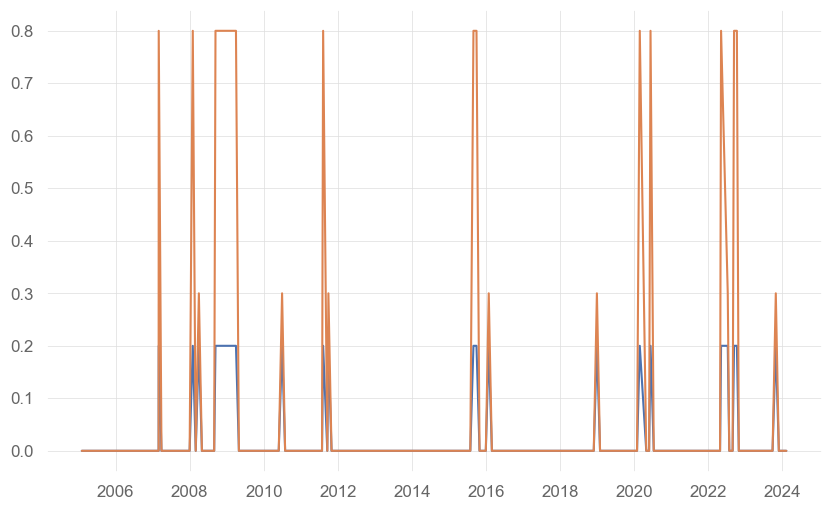

In [45]:
if include_ro_etf:
    plt.plot(dfw_risk_mom['RO'])
plt.plot(dfw_risk_mom['CASH'])

In [46]:
results_risk_mom, _ = run_backtest(dfw_risk_mom, 10000)
results_risk_ewmac, _ = run_backtest(dfw_risk_ewmac, 10000)

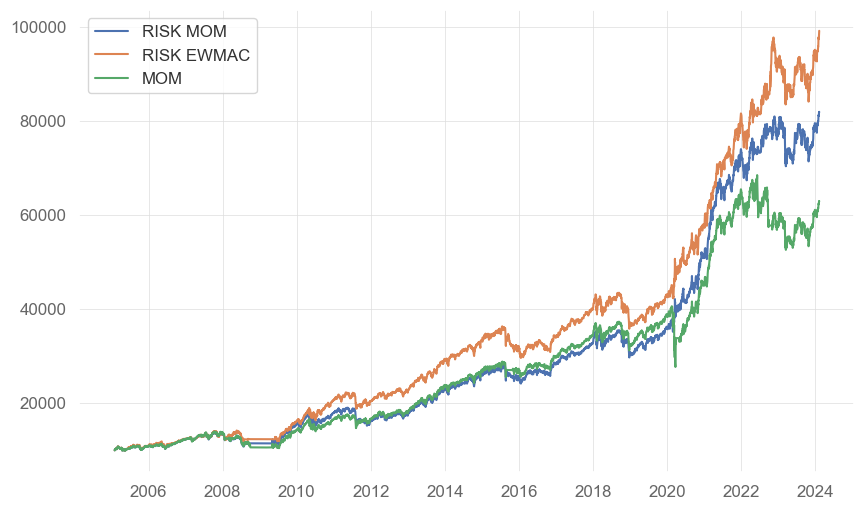

In [47]:
plt.plot(results_risk_mom['Cumulative'], label = 'RISK MOM')
plt.plot(results_risk_ewmac['Cumulative'], label = 'RISK EWMAC')
plt.plot(results_mom['Cumulative'], label='MOM')
plt.legend()

In [48]:
qs.reports.metrics(returns=results_risk_mom['Returns'], benchmark=results_risk_ewmac['Returns'])

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2005-02-01   2005-02-01
End Period          2024-02-09   2024-02-09
Risk-Free Rate      0.0%         0.0%
Time in Market      96.0%        96.0%

Cumulative Return   884.5%       712.25%
CAGR﹪              8.65%        7.89%

Sharpe              0.95         0.87
Prob. Sharpe Ratio  100.0%       99.99%
Sortino             1.34         1.24
Sortino/√2          0.95         0.87
Omega               1.17         1.17

Max Drawdown        -18.49%      -22.2%
Longest DD Days     589          702

Gain/Pain Ratio     0.19         0.17
Gain/Pain (1M)      1.29         1.2

Payoff Ratio        1.06         1.05
Profit Factor       1.19         1.17
Common Sense Ratio  1.15         1.16
CPC Index           0.67         0.65
Tail Ratio          0.96         0.99
Outlier Win Ratio   3.92         3.89
Outlier Loss Ratio  4.19         4.19

MTD                 3.48%        2.48%
3M             

In [49]:
qs.reports.metrics(returns=results_risk_ewmac['Returns'], benchmark=results_mom['Returns'])

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2005-02-01   2005-02-01
End Period          2024-02-09   2024-02-09
Risk-Free Rate      0.0%         0.0%
Time in Market      95.0%        96.0%

Cumulative Return   524.17%      884.5%
CAGR﹪              6.87%        8.65%

Sharpe              0.69         0.95
Prob. Sharpe Ratio  99.86%       100.0%
Sortino             0.97         1.34
Sortino/√2          0.69         0.95
Omega               1.19         1.19

Max Drawdown        -31.68%      -18.49%
Longest DD Days     772          589

Gain/Pain Ratio     0.15         0.19
Gain/Pain (1M)      1.01         1.29

Payoff Ratio        1.02         1.04
Profit Factor       1.15         1.19
Common Sense Ratio  1.07         1.15
CPC Index           0.62         0.66
Tail Ratio          0.93         0.96
Outlier Win Ratio   3.87         4.05
Outlier Loss Ratio  4.05         4.43

MTD                 2.48%        3.48%
3M            

In [50]:
bm_comp = get_data(yf.Ticker('^SP500TR')) 
bm_comp.index = bm_comp.index.tz_localize(None)
bm_comp = bm_comp[results_risk_mom.first_valid_index():].copy()
bm_comp/=bm_comp.iloc[0]

In [51]:
qs.reports.metrics(returns=results_risk_ewmac['Returns'], benchmark=bm_comp.pct_change().fillna(0))

                    Benchmark    Strategy
------------------  -----------  ----------
Start Period        2005-02-01   2005-02-01
End Period          2024-02-09   2024-02-09
Risk-Free Rate      0.0%         0.0%
Time in Market      100.0%       96.0%

Cumulative Return   516.45%      884.5%
CAGR﹪              6.82%        8.65%

Sharpe              0.59         0.95
Prob. Sharpe Ratio  99.47%       100.0%
Sortino             0.83         1.34
Sortino/√2          0.58         0.95
Omega               1.19         1.19

Max Drawdown        -55.25%      -18.49%
Longest DD Days     1634         589

Gain/Pain Ratio     0.12         0.19
Gain/Pain (1M)      0.77         1.29

Payoff Ratio        0.91         0.98
Profit Factor       1.12         1.19
Common Sense Ratio  1.04         1.15
CPC Index           0.56         0.62
Tail Ratio          0.92         0.96
Outlier Win Ratio   3.67         4.76
Outlier Loss Ratio  3.64         5.0

MTD                 3.77%        3.48%
3M             

                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2005-02-01   2005-02-01
End Period                 2024-02-09   2024-02-09
Risk-Free Rate             0.0%         0.0%
Time in Market             100.0%       96.0%

Cumulative Return          520.71%      891.48%
CAGR﹪                     6.85%        8.68%

Sharpe                     0.59         0.95
Prob. Sharpe Ratio         99.48%       100.0%
Smart Sharpe               0.56         0.91
Sortino                    0.83         1.35
Smart Sortino              0.79         1.28
Sortino/√2                 0.59         0.95
Smart Sortino/√2           0.56         0.91
Omega                      1.19         1.19

Max Drawdown               -55.25%      -18.49%
Longest DD Days            1634         589
Volatility (ann.)          19.44%       13.69%
R^2                        0.31         0.31
Information Ratio          0.01         0.01
Calmar              

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2015-07-21,2016-01-20,2017-02-28,589,-18.494397,-17.594870
2,2018-09-14,2018-12-24,2020-01-15,489,-17.593103,-15.904079
3,2008-05-20,2008-07-25,2009-09-09,478,-16.442504,-16.062475
4,2011-05-03,2011-08-15,2012-04-30,364,-15.300074,-15.232683
5,2022-11-16,2023-03-15,2024-02-01,443,-14.552677,-13.496090


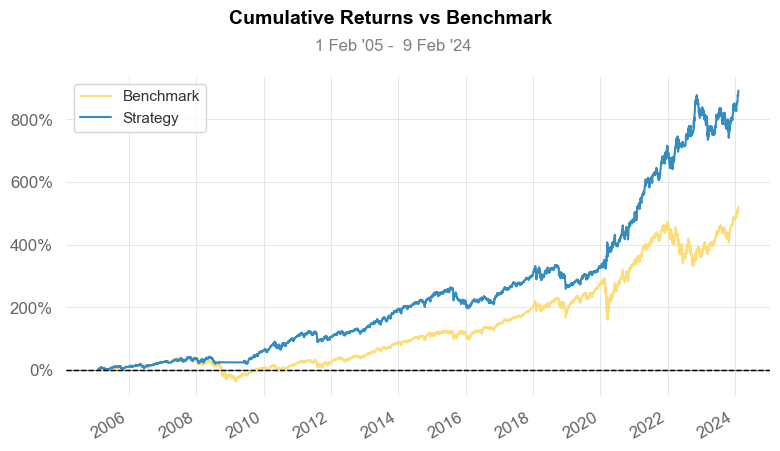

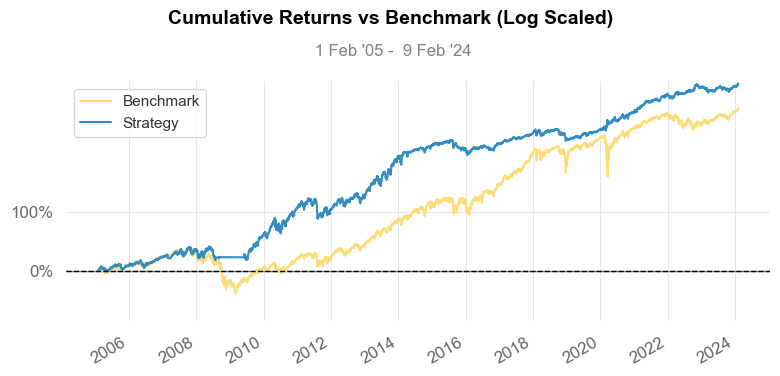

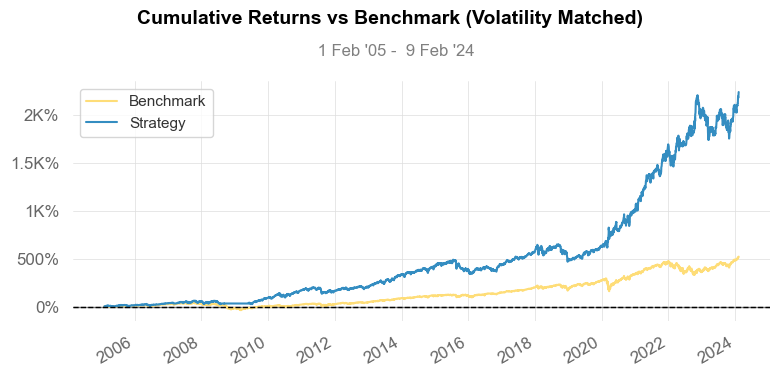

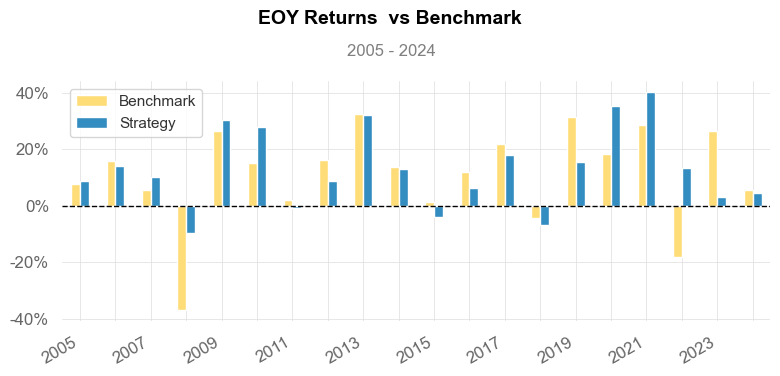

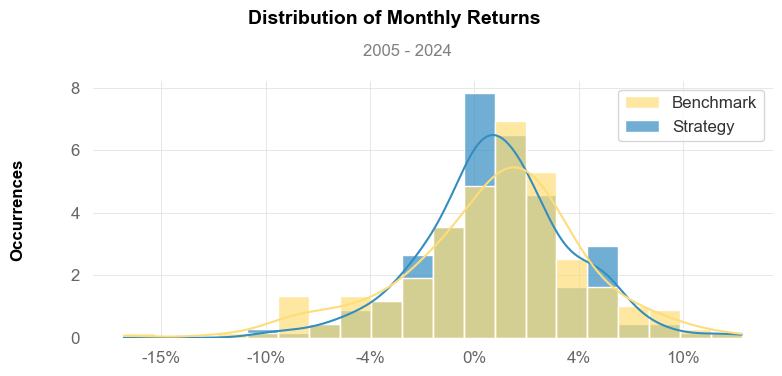

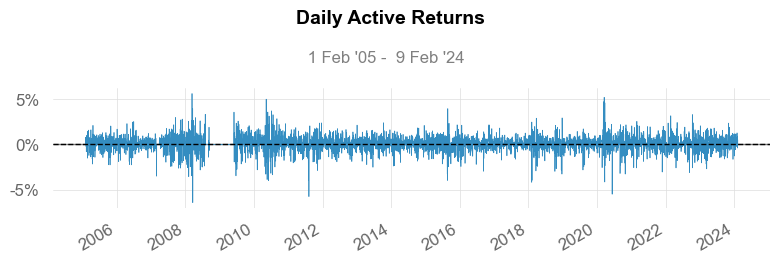

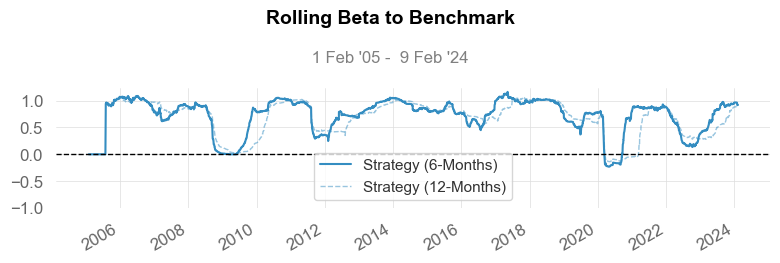

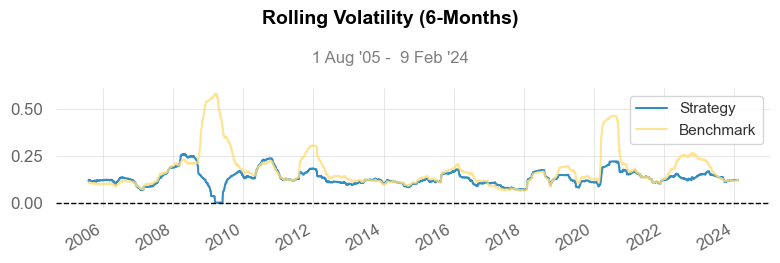

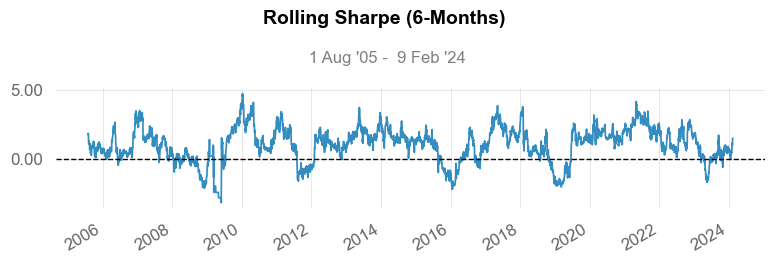

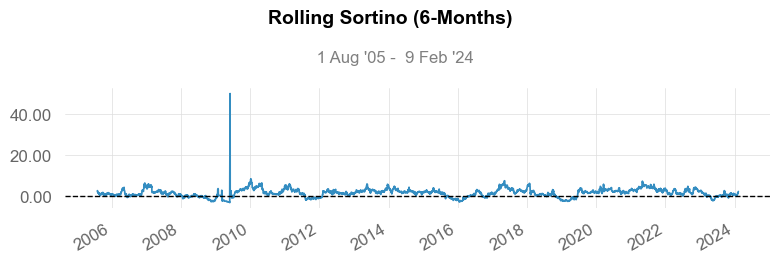

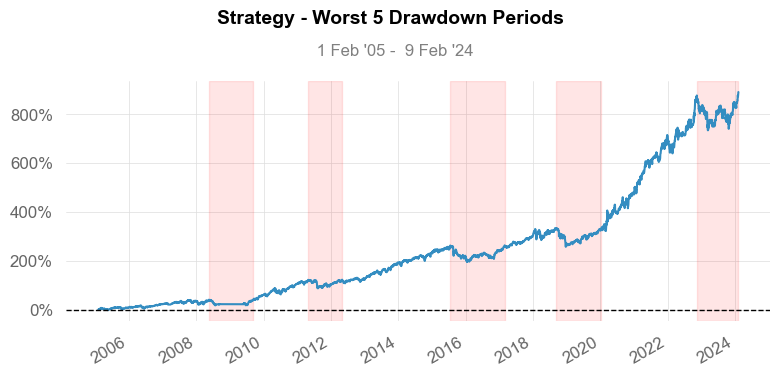

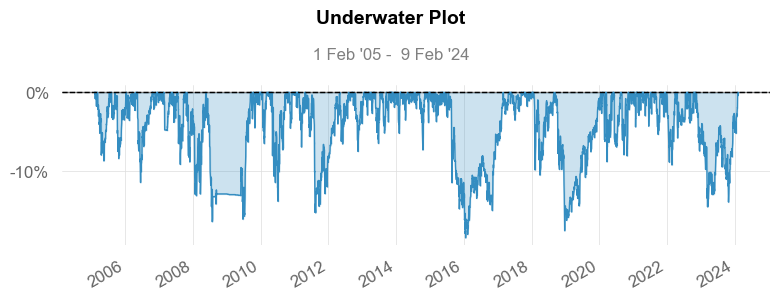

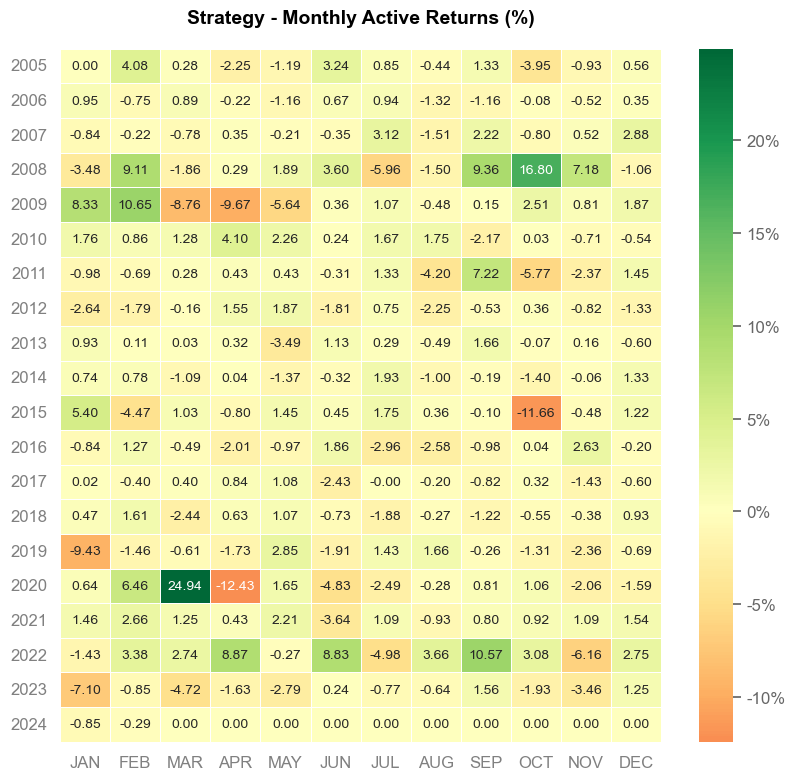

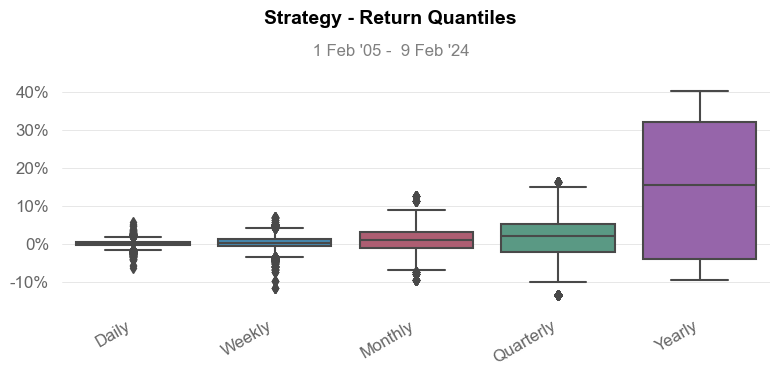

In [52]:
qs.reports.full(returns=results_risk_ewmac['Cumulative'], 
                benchmark=bm_comp.pct_change().fillna(0),
                output='report.html', 
                title='Volatility Targeted Strategy')

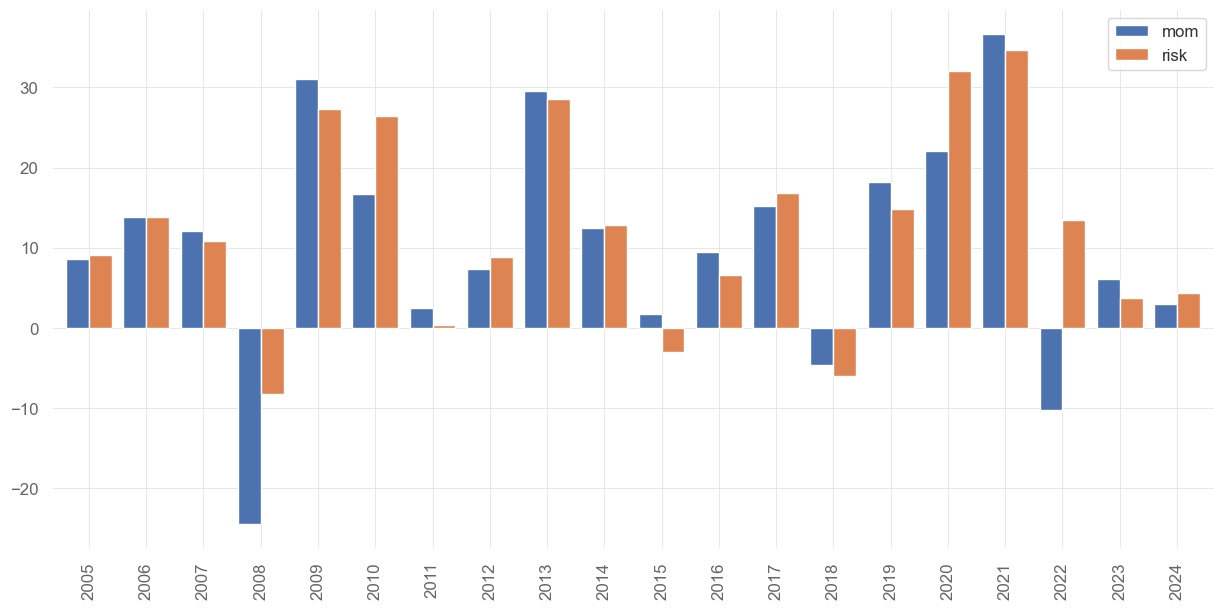

In [54]:
yearly_returns_mom = ((results_mom['Returns']).groupby([results_mom['Returns'].index.year]).sum()*100)
yearly_returns_risk = ((results_risk_ewmac['Returns']).groupby([results_risk_ewmac['Returns'].index.year]).sum()*100)
comb_returns = pd.concat([yearly_returns_mom, yearly_returns_risk], axis=1)
comb_returns.columns = ['mom', 'risk']
comb_returns.plot(kind='bar', width=0.8, figsize=(15,7));

In [ ]:
## PCA

In [55]:
from sklearn.decomposition import PCA
prices = full_df.copy()
if 'RO' in prices.columns:
    del prices['RO']
    
if 'CASH' in prices.columns:
    del prices['CASH']

returns = np.log(prices).diff().dropna()

In [56]:
def run_pca(x):
    pca = PCA(n_components=1)
    pca.fit(X=x)
    return pca.explained_variance_ratio_[0]


In [57]:
lookback=40
_expl_var = []
for i, (idx, _) in enumerate(returns.iterrows()):
    if i < lookback:
        _expl_var.append(0)
    else:
        _expl_var.append(run_pca(returns.iloc[i-lookback:i]))

<Axes: xlabel='Date'>

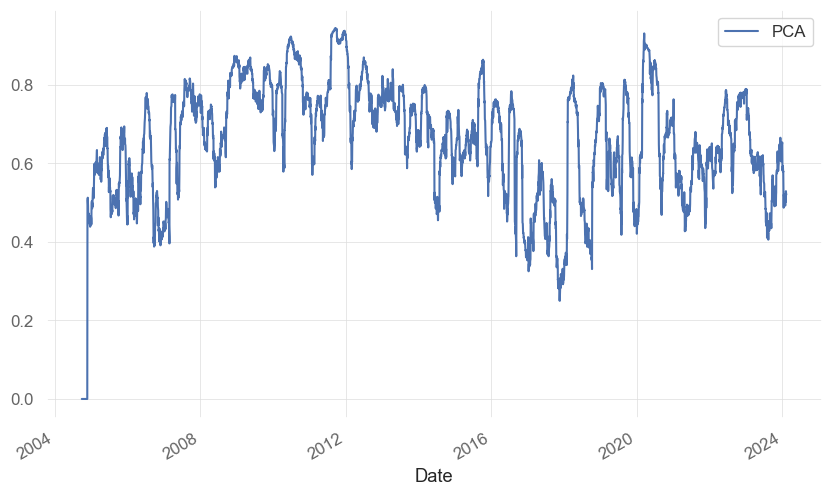

In [58]:
expl_var = pd.DataFrame(_expl_var, index = returns.index, columns = ['PCA'])
expl_var.plot()

In [59]:
expl_var['strategy'] = results_mom['Cumulative']

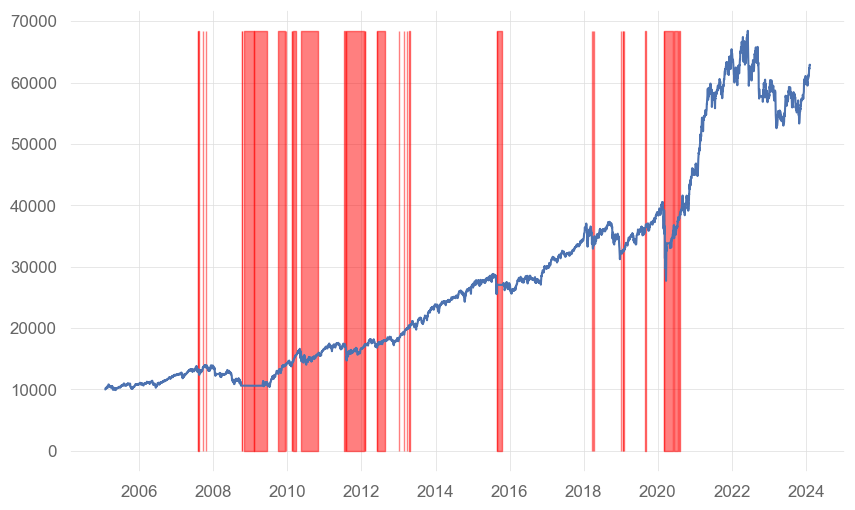

In [60]:
fig, ax = plt.subplots()
ax.plot(expl_var['strategy'])
ax.fill_between(expl_var.index, 0, expl_var['strategy'].max(), where=expl_var['PCA']>0.8, color='red', alpha=0.5)